Using device: cuda
Epoch [100/2000], Loss: 3.1685
Epoch [200/2000], Loss: 0.4569
Epoch [300/2000], Loss: 0.1525
Epoch [400/2000], Loss: 0.0967
Epoch [500/2000], Loss: 0.0678
Epoch [600/2000], Loss: 0.0564
Epoch [700/2000], Loss: 0.0535
Epoch [800/2000], Loss: 0.0404
Epoch [900/2000], Loss: 0.0545
Epoch [1000/2000], Loss: 0.0667
Epoch [1100/2000], Loss: 0.0309
Epoch [1200/2000], Loss: 0.0563
Epoch [1300/2000], Loss: 0.0605
Epoch [1400/2000], Loss: 0.0535
Epoch [1500/2000], Loss: 0.0244
Epoch [1600/2000], Loss: 0.0449
Epoch [1700/2000], Loss: 0.0556
Epoch [1800/2000], Loss: 0.0291
Epoch [1900/2000], Loss: 0.0971
Epoch [2000/2000], Loss: 0.0206
Model saved to ./black_scholes_model.pt

--- Evaluation Metrics ---
Training set: MSE = 0.0182, MAE = 0.0841, StdError = 0.1313, MPPD  = -0.0320
Test set: MSE = 0.2460, MAE = 0.2822, StdError = 0.4957, MPPD = -0.0520

Results saved to train_test_predictions_and_metrics.xlsx with separate sheets for train/test/metrics


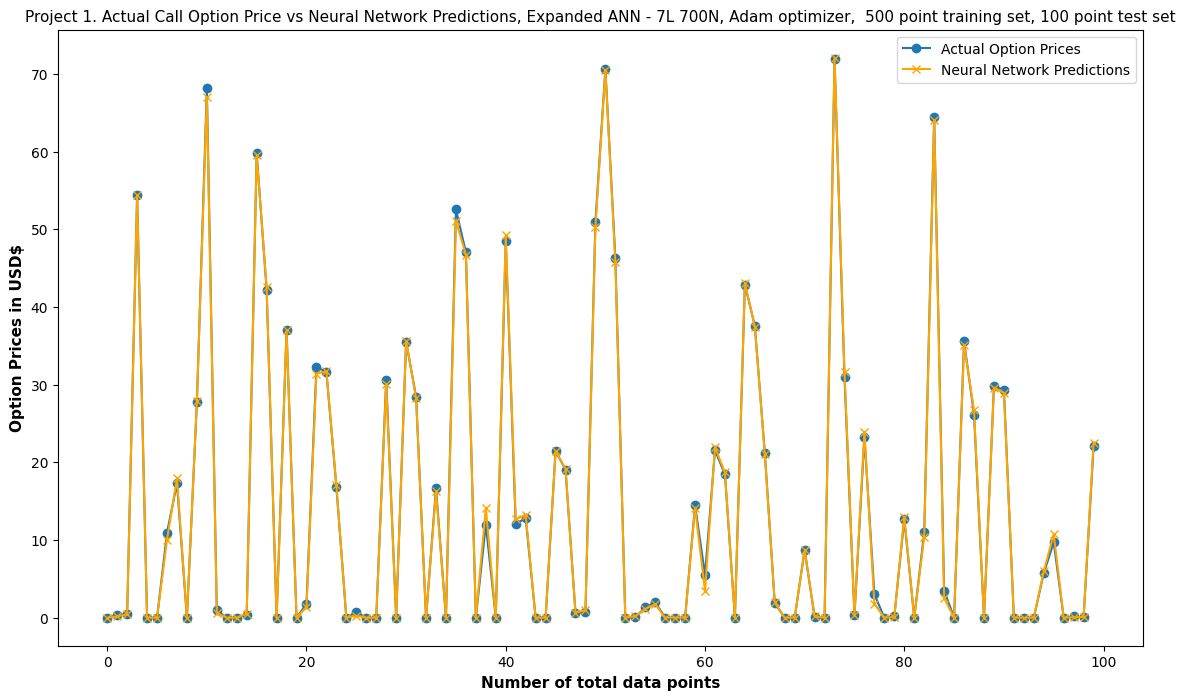

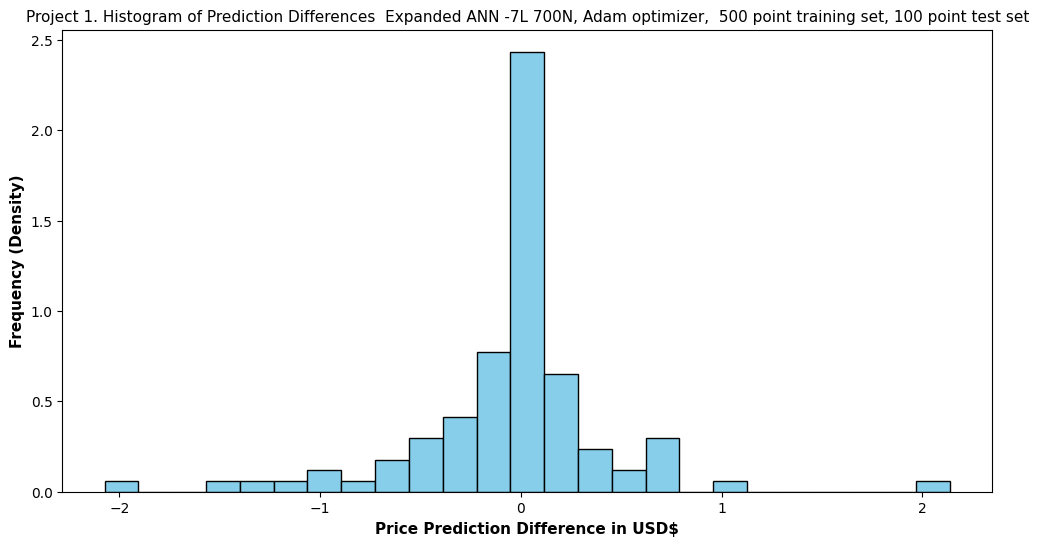

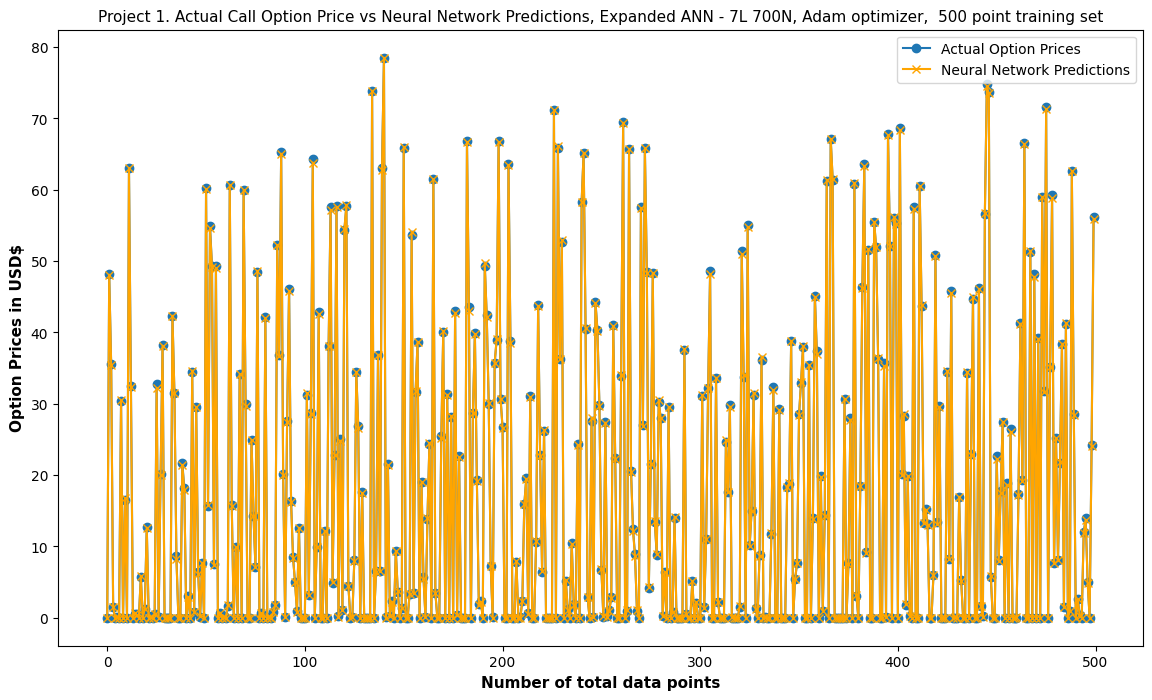

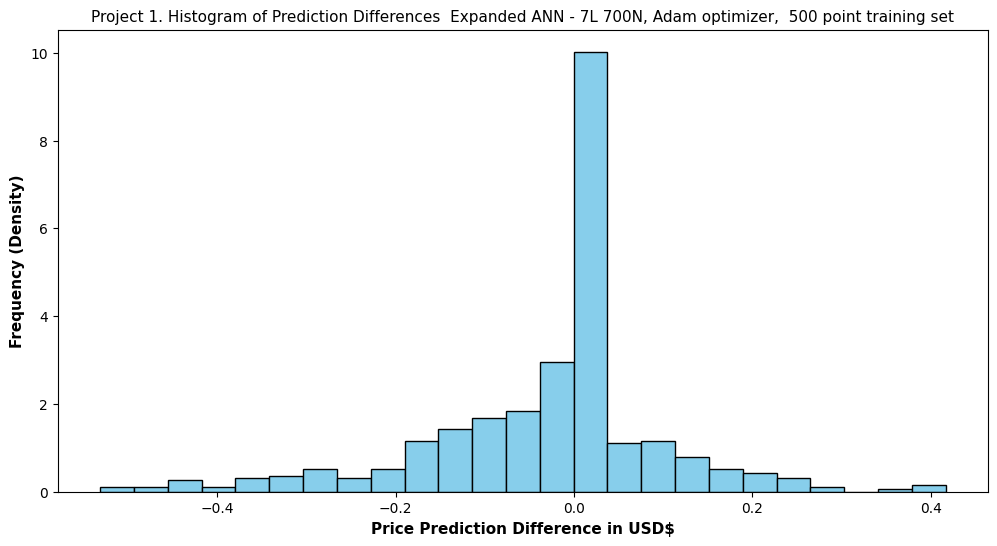

In [1]:
# Imports 
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import os
import xlsxwriter



# Reproducibility 
train_seed = 42
test_seed = 100
torch.manual_seed(train_seed)
np.random.seed(train_seed)
random.seed(train_seed)
torch.cuda.manual_seed(train_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#  Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#  Black-Scholes Function 
def BlackScholes_Call_Price(Spot_Price, Strike_Price, Time_Maturity, Risk_FreeRate, Volatility):
    assert Spot_Price.shape == Strike_Price.shape == Time_Maturity.shape == Risk_FreeRate.shape == Volatility.shape
    D1 = (np.log(Spot_Price / Strike_Price) + (Risk_FreeRate + 0.5 * Volatility**2) * Time_Maturity) / (Volatility * np.sqrt(Time_Maturity))
    D2 = D1 - Volatility * np.sqrt(Time_Maturity)
    NormalD1 = norm.cdf(D1)
    NormalD2 = norm.cdf(D2)
    Call_Price = Spot_Price * NormalD1 - Strike_Price * np.exp(-Risk_FreeRate * Time_Maturity) * NormalD2
    return Call_Price, NormalD1, NormalD2

#  Generate Training Data 
size_train = 500 #used in the Project. training sizes:100, 375,650,815,1035,1325,2200,3500,6500,15000
np.random.seed(train_seed)
Spot_Price = np.random.uniform(0, 100, size=size_train)
Strike_Price = np.random.uniform(20, 80, size=size_train)
TimeMaturity = np.random.uniform(0.04, 2, size=size_train)
RiskFreeRate = np.random.uniform(0, 0.2, size=size_train)
Volatility = np.random.uniform(0, 0.35, size=size_train)

OptionPrices, _, _ = BlackScholes_Call_Price(Spot_Price, Strike_Price, TimeMaturity, RiskFreeRate, Volatility)

data_train = pd.DataFrame({
    'Spot-Price': Spot_Price,
    'Strike-Price': Strike_Price,
    'Risk-Free-Rate': RiskFreeRate,
    'Time-to-Maturity': TimeMaturity,
    'Volatility': Volatility,
    'Call-Option-Price': OptionPrices
})

features_train = data_train[['Spot-Price', 'Strike-Price', 'Risk-Free-Rate', 'Time-to-Maturity', 'Volatility']]
target_train = data_train['Call-Option-Price']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(features_train)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(target_train.values, dtype=torch.float32).view(-1, 1).to(device)

#  Define Neural Network 
class BlackScholesNN(nn.Module):
    def __init__(self, Input_param, Hidden_Size, Num_Hidden_Layers, Output_param):
        super(BlackScholesNN, self).__init__()
        layers = []
        in_features = Input_param
        for _ in range(Num_Hidden_Layers):
            layers.append(nn.Linear(in_features, Hidden_Size))
            layers.append(nn.ReLU())
            in_features = Hidden_Size
        layers.append(nn.Linear(in_features, Output_param))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

Input_param = X_train_tensor.shape[1]
Output_param = 1
Hidden_Size =  100
Num_Hidden_Layers = 7
model = BlackScholesNN(Input_param, Hidden_Size, Num_Hidden_Layers, Output_param).to(device)

#  Loss and Optimizer 
ErrorCriterion = nn.MSELoss()
MAE_Criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
Epoch_Size = 2000

# Training Loop 
for Ep in range(Epoch_Size):
    model.train()
    outputs = model(X_train_tensor)
    loss = ErrorCriterion(outputs, Y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (Ep + 1) % 100 == 0:
        print(f'Epoch [{Ep+1}/{Epoch_Size}], Loss: {loss.item():.4f}')

# Save Trained Model 
model_path = './black_scholes_model.pt'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")



#  Predictions on Training Set 
with torch.no_grad():
    model.eval()
    train_preds = torch.clamp(model(X_train_tensor), min=0)

Tailored_train_preds_np = train_preds.cpu().numpy().squeeze()

# Independent Test Dataset 
size_test = 100
np.random.seed(test_seed)
Spot_Price_test = np.random.uniform(0, 100, size_test)
Strike_Price_test = np.random.uniform(20, 80, size_test)
TimeMaturity_test = np.random.uniform(0.04, 2, size_test)
RiskFreeRate_test = np.random.uniform(0, 0.2, size_test)
Volatility_test = np.random.uniform(0, 0.35, size_test)

# Compute option prices
OptionPrices_test, _, _ = BlackScholes_Call_Price(
    Spot_Price_test, Strike_Price_test, TimeMaturity_test, RiskFreeRate_test, Volatility_test
)

# Create test dataframe
data_test = pd.DataFrame({
    'Spot-Price': Spot_Price_test,
    'Strike-Price': Strike_Price_test,
    'Risk-Free-Rate': RiskFreeRate_test,
    'Time-to-Maturity': TimeMaturity_test,
    'Volatility': Volatility_test,
    'Call-Option-Price': OptionPrices_test
})

# Scale test features
features_test = data_test[['Spot-Price', 'Strike-Price', 'Risk-Free-Rate', 'Time-to-Maturity', 'Volatility']]
X_test_scaled = scaler.transform(features_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

#  Predictions on Test Set 
with torch.no_grad():
    model.eval()
    test_preds = torch.clamp(model(X_test_tensor), min=0)

Tailored_test_preds_np = test_preds.cpu().numpy().squeeze()

#  Combine Data 
Predictions_Data = pd.concat([
    data_train.reset_index(drop=True),
    pd.DataFrame(Tailored_train_preds_np, columns=['Neural Network Prediction'])
], axis=1)
Predictions_Data['Prediction-Difference'] = Predictions_Data['Neural Network Prediction'] - Predictions_Data['Call-Option-Price']

Predictions_Test = pd.concat([
    data_test.reset_index(drop=True),
    pd.DataFrame(Tailored_test_preds_np, columns=['Neural Network Prediction'])
], axis=1)
Predictions_Test['Prediction-Difference'] = Predictions_Test['Neural Network Prediction'] - Predictions_Test['Call-Option-Price']

#  Compute Metrics
MeanSquaredLoss = ErrorCriterion(torch.tensor(Tailored_train_preds_np).view(-1,1), Y_train_tensor.cpu()).item()
MeanAbsLoss = MAE_Criterion(torch.tensor(Tailored_train_preds_np).view(-1,1), Y_train_tensor.cpu()).item()
MeanError = Predictions_Data['Prediction-Difference'].mean()
StdError = Predictions_Data['Prediction-Difference'].std()  

MeanSquaredLoss_test = ErrorCriterion(torch.tensor(Tailored_test_preds_np).view(-1,1), torch.tensor(data_test['Call-Option-Price'].values).view(-1,1)).item()
MeanAbsLoss_test = MAE_Criterion(torch.tensor(Tailored_test_preds_np).view(-1,1), torch.tensor(data_test['Call-Option-Price'].values).view(-1,1)).item()
MeanError_test = Predictions_Test['Prediction-Difference'].mean()
StdError_test = Predictions_Test['Prediction-Difference'].std()

#  Print Metrics 
print("\n--- Evaluation Metrics ---")
print(f"Training set: MSE = {MeanSquaredLoss:.4f}, MAE = {MeanAbsLoss:.4f}, StdError = {StdError:.4f}, MPPD  = {MeanError:.4f}")
print(f"Test set: MSE = {MeanSquaredLoss_test:.4f}, MAE = {MeanAbsLoss_test:.4f}, StdError = {StdError_test:.4f}, MPPD = {MeanError_test:.4f}")

# Save All Results to a Single Excel File with Multiple Sheets 
with pd.ExcelWriter('_500.xlsx', engine='xlsxwriter') as writer:
    # Training predictions sheet
    Predictions_Data.to_excel(writer, sheet_name='Train Predictions', index=False)
    
    # Test predictions sheet
    Predictions_Test.to_excel(writer, sheet_name='Test Predictions', index=False)
    
    # Metrics summary sheet
    metrics_df = pd.DataFrame({
        'Dataset': ['Train', 'Test'],
        'MSE': [MeanSquaredLoss, MeanSquaredLoss_test],
        'MAE': [MeanAbsLoss, MeanAbsLoss_test],
        'StdError': [StdError, StdError_test],
        'Mean Price Prediction Difference': [MeanError, MeanError_test]
    })
    metrics_df.to_excel(writer, sheet_name='Metrics Summary', index=False)

print("\nResults saved to train_test_predictions_and_metrics.xlsx with separate sheets for train/test/metrics")



plt.figure(figsize=(14, 8))
plt.plot(Predictions_Test.index, Predictions_Test['Call-Option-Price'], label='Actual Option Prices', marker='o')
plt.plot(Predictions_Test.index, Predictions_Test['Neural Network Prediction'], label='Neural Network Predictions', marker='x', color='orange')
plt.title('Project 1. Actual Call Option Price vs Neural Network Predictions, Expanded ANN - 7L 700N, Adam optimizer,  500 point training set, 100 point test set', fontsize=11)
plt.xlabel('Number of total data points', fontsize=11, fontweight='bold')
plt.ylabel('Option Prices in USD$', fontsize=11, fontweight='bold')
plt.legend()
plt.savefig('Option_Price_Predictions_7_Layers_700_Neurons_500_Data_Points_500.pdf', bbox_inches='tight', dpi=300)
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(Predictions_Test['Prediction-Difference'], bins=25, color='skyblue', edgecolor='black', density=True)
plt.title('Project 1. Histogram of Prediction Differences  Expanded ANN -7L 700N, Adam optimizer,  500 point training set, 100 point test set', fontsize=11)
plt.xlabel('Price Prediction Difference in USD$', fontsize=11, fontweight='bold')
plt.ylabel('Frequency (Density)', fontsize=11, fontweight='bold')
plt.savefig('Histogram_Prediction_Differences_7_Layers_700_Neurons_100_Data_Points_500.pdf', bbox_inches='tight', dpi=300)
plt.show()


# Plots
plt.figure(figsize=(14, 8))
plt.plot(Predictions_Data.index, Predictions_Data['Call-Option-Price'], label='Actual Option Prices', marker='o')
plt.plot(Predictions_Data.index, Predictions_Data['Neural Network Prediction'], label='Neural Network Predictions', marker='x', color='orange')
plt.title('Project 1. Actual Call Option Price vs Neural Network Predictions, Expanded ANN - 7L 700N, Adam optimizer,  500 point training set', fontsize=11)
plt.xlabel('Number of total data points', fontsize=11, fontweight='bold')
plt.ylabel('Option Prices in USD$', fontsize=11, fontweight='bold')
plt.legend()
plt.savefig('Option_Price_Predictions_7_Layers_700_Neurons_500_Data_Points.pdf', bbox_inches='tight', dpi=300)
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(Predictions_Data['Prediction-Difference'], bins=25, color='skyblue', edgecolor='black', density=True)
plt.title('Project 1. Histogram of Prediction Differences  Expanded ANN - 7L 700N, Adam optimizer,  500 point training set', fontsize=11)
plt.xlabel('Price Prediction Difference in USD$', fontsize=11, fontweight='bold')
plt.ylabel('Frequency (Density)', fontsize=11, fontweight='bold')
plt.savefig('Histogram_Prediction_Differences_7_Layers_700_Neurons_500_Data_Points.pdf', bbox_inches='tight', dpi=300)
plt.show()
